# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'               # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11564
EM converged at iteration 12, llf=-11391, convergence criterion=8.5084e-07 < tolerance=1e-06
EM start iterations, llf=-11576
EM converged at iteration 12, llf=-11403, convergence criterion=8.464e-07 < tolerance=1e-06
EM start iterations, llf=-11634
EM converged at iteration 12, llf=-11458, convergence criterion=8.3147e-07 < tolerance=1e-06
EM start iterations, llf=-11641
EM converged at iteration 12, llf=-11465, convergence criterion=8.3185e-07 < tolerance=1e-06
EM start iterations, llf=-11707
EM converged at iteration 11, llf=-11533, convergence criterion=9.502e-07 < tolerance=1e-06
EM start iterations, llf=-11715
EM converged at iteration 11, llf=-11542, convergence criterion=9.481e-07 < tolerance=1e-06
EM start iterations, llf=-11766
EM converged at iteration 11, llf=-11594, convergence criterion=9.3302e-07 < tolerance=1e-06
EM start iterations, llf=-11766
EM converged at iteration 11, llf=-11594, convergence criterion=9.3302e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-13039
EM converged at iteration 12, llf=-12867, convergence criterion=9.896e-07 < tolerance=1e-06
EM start iterations, llf=-13097
EM converged at iteration 13, llf=-12926, convergence criterion=8.6722e-07 < tolerance=1e-06
EM start iterations, llf=-13109
EM converged at iteration 13, llf=-12938, convergence criterion=8.7401e-07 < tolerance=1e-06
EM start iterations, llf=-13161
EM converged at iteration 13, llf=-12987, convergence criterion=8.6761e-07 < tolerance=1e-06
EM start iterations, llf=-13161
EM converged at iteration 13, llf=-12987, convergence criterion=8.6761e-07 < tolerance=1e-06
EM start iterations, llf=-13171
EM converged at iteration 13, llf=-12997, convergence criterion=9.0303e-07 < tolerance=1e-06
EM start iterations, llf=-13219
EM converged at iteration 13, llf=-13043, convergence criterion=9.3309e-07 < tolerance=1e-06
EM start iterations, llf=-13225
EM converged at iteration 13, llf=-13049, convergence criterion=9.2651e-07 < tolerance=1e-06
E

EM start iterations, llf=-14708
EM converged at iteration 12, llf=-14518, convergence criterion=8.7741e-07 < tolerance=1e-06
EM start iterations, llf=-14708
EM converged at iteration 12, llf=-14518, convergence criterion=8.7741e-07 < tolerance=1e-06
EM start iterations, llf=-14718
EM converged at iteration 12, llf=-14528, convergence criterion=8.7338e-07 < tolerance=1e-06
EM start iterations, llf=-14768
EM converged at iteration 12, llf=-14578, convergence criterion=8.9045e-07 < tolerance=1e-06
EM start iterations, llf=-14778
EM converged at iteration 12, llf=-14588, convergence criterion=8.808e-07 < tolerance=1e-06
EM start iterations, llf=-14826
EM converged at iteration 12, llf=-14636, convergence criterion=8.7517e-07 < tolerance=1e-06
EM start iterations, llf=-14835
EM converged at iteration 12, llf=-14643, convergence criterion=8.6703e-07 < tolerance=1e-06
EM start iterations, llf=-14882
EM converged at iteration 12, llf=-14691, convergence criterion=8.6949e-07 < tolerance=1e-06
E

EM start iterations, llf=-16420
EM converged at iteration 11, llf=-16214, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-16425
EM converged at iteration 12, llf=-16219, convergence criterion=8.3295e-07 < tolerance=1e-06
EM start iterations, llf=-16477
EM converged at iteration 11, llf=-16271, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-16485
EM converged at iteration 11, llf=-16279, convergence criterion=9.976e-07 < tolerance=1e-06
EM start iterations, llf=-16539
EM converged at iteration 12, llf=-16332, convergence criterion=8.3397e-07 < tolerance=1e-06
EM start iterations, llf=-16539
EM converged at iteration 12, llf=-16332, convergence criterion=8.3397e-07 < tolerance=1e-06
EM start iterations, llf=-16548
EM converged at iteration 11, llf=-16338, convergence criterion=9.9842e-07 < tolerance=1e-06
EM start iterations, llf=-16597
EM converged at iteration 11, llf=-16387, convergence criterion=9.8988e-07 < tolerance=1e-06
E

EM start iterations, llf=-17895
EM converged at iteration 11, llf=-17681, convergence criterion=9.611e-07 < tolerance=1e-06
EM start iterations, llf=-17953
EM converged at iteration 11, llf=-17738, convergence criterion=9.3362e-07 < tolerance=1e-06
EM start iterations, llf=-17953
EM converged at iteration 11, llf=-17738, convergence criterion=9.3362e-07 < tolerance=1e-06
EM start iterations, llf=-17958
EM converged at iteration 11, llf=-17744, convergence criterion=9.3562e-07 < tolerance=1e-06
EM start iterations, llf=-18011
EM converged at iteration 11, llf=-17797, convergence criterion=9.5031e-07 < tolerance=1e-06
EM start iterations, llf=-18018
EM converged at iteration 11, llf=-17804, convergence criterion=9.4836e-07 < tolerance=1e-06
EM start iterations, llf=-18073
EM converged at iteration 11, llf=-17857, convergence criterion=9.3808e-07 < tolerance=1e-06
EM start iterations, llf=-18081
EM converged at iteration 11, llf=-17864, convergence criterion=9.4075e-07 < tolerance=1e-06
E

EM converged at iteration 13, llf=-11962, convergence criterion=9.949e-07 < tolerance=1e-06
EM start iterations, llf=-12142
EM converged at iteration 14, llf=-11965, convergence criterion=8.5295e-07 < tolerance=1e-06
EM start iterations, llf=-12228
EM converged at iteration 13, llf=-12060, convergence criterion=8.658e-07 < tolerance=1e-06
EM start iterations, llf=-12227
EM converged at iteration 13, llf=-12061, convergence criterion=8.5934e-07 < tolerance=1e-06
EM start iterations, llf=-12177
EM converged at iteration 15, llf=-12008, convergence criterion=8.9616e-07 < tolerance=1e-06
EM start iterations, llf=-12182
EM converged at iteration 14, llf=-12015, convergence criterion=9.9181e-07 < tolerance=1e-06
EM start iterations, llf=-12149
EM converged at iteration 15, llf=-11982, convergence criterion=9.3207e-07 < tolerance=1e-06
EM start iterations, llf=-12149
EM converged at iteration 15, llf=-11982, convergence criterion=9.3207e-07 < tolerance=1e-06
EM start iterations, llf=-12141
EM

EM start iterations, llf=-13545
EM converged at iteration 15, llf=-13368, convergence criterion=9.3757e-07 < tolerance=1e-06
EM start iterations, llf=-13575
EM converged at iteration 15, llf=-13400, convergence criterion=9.205e-07 < tolerance=1e-06
EM start iterations, llf=-13577
EM converged at iteration 15, llf=-13401, convergence criterion=9.5572e-07 < tolerance=1e-06
EM start iterations, llf=-13614
EM converged at iteration 15, llf=-13433, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-13614
EM converged at iteration 15, llf=-13433, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-13624
EM converged at iteration 15, llf=-13443, convergence criterion=9.6605e-07 < tolerance=1e-06
EM start iterations, llf=-13671
EM converged at iteration 15, llf=-13490, convergence criterion=9.3813e-07 < tolerance=1e-06
EM start iterations, llf=-13679
EM converged at iteration 15, llf=-13499, convergence criterion=9.2651e-07 < tolerance=1e-06
E

EM start iterations, llf=-15263
EM converged at iteration 15, llf=-15060, convergence criterion=9.6156e-07 < tolerance=1e-06
EM start iterations, llf=-15263
EM converged at iteration 15, llf=-15060, convergence criterion=9.6156e-07 < tolerance=1e-06
EM start iterations, llf=-15272
EM converged at iteration 15, llf=-15071, convergence criterion=9.9577e-07 < tolerance=1e-06
EM start iterations, llf=-15324
EM converged at iteration 15, llf=-15122, convergence criterion=9.8414e-07 < tolerance=1e-06
EM start iterations, llf=-15328
EM converged at iteration 16, llf=-15125, convergence criterion=8.9516e-07 < tolerance=1e-06
EM start iterations, llf=-15387
EM converged at iteration 16, llf=-15183, convergence criterion=9.043e-07 < tolerance=1e-06
EM start iterations, llf=-15391
EM converged at iteration 16, llf=-15188, convergence criterion=9.0323e-07 < tolerance=1e-06
EM start iterations, llf=-15434
EM converged at iteration 16, llf=-15230, convergence criterion=9.1228e-07 < tolerance=1e-06
E

EM start iterations, llf=-16954
EM converged at iteration 15, llf=-16738, convergence criterion=9.3771e-07 < tolerance=1e-06
EM start iterations, llf=-16959
EM converged at iteration 15, llf=-16743, convergence criterion=9.3292e-07 < tolerance=1e-06
EM start iterations, llf=-17013
EM converged at iteration 15, llf=-16797, convergence criterion=9.5252e-07 < tolerance=1e-06
EM start iterations, llf=-17022
EM converged at iteration 15, llf=-16806, convergence criterion=9.6073e-07 < tolerance=1e-06
EM start iterations, llf=-17067
EM converged at iteration 15, llf=-16850, convergence criterion=9.6937e-07 < tolerance=1e-06
EM start iterations, llf=-17067
EM converged at iteration 15, llf=-16850, convergence criterion=9.6937e-07 < tolerance=1e-06
EM start iterations, llf=-17086
EM converged at iteration 15, llf=-16870, convergence criterion=9.6361e-07 < tolerance=1e-06
EM start iterations, llf=-17138
EM converged at iteration 15, llf=-16920, convergence criterion=9.5706e-07 < tolerance=1e-06


EM start iterations, llf=-18434
EM converged at iteration 14, llf=-18210, convergence criterion=9.7697e-07 < tolerance=1e-06
EM start iterations, llf=-18484
EM converged at iteration 14, llf=-18259, convergence criterion=9.7552e-07 < tolerance=1e-06
EM start iterations, llf=-18484
EM converged at iteration 14, llf=-18259, convergence criterion=9.7552e-07 < tolerance=1e-06
EM start iterations, llf=-18492
EM converged at iteration 14, llf=-18267, convergence criterion=9.6923e-07 < tolerance=1e-06
EM start iterations, llf=-18546
EM converged at iteration 14, llf=-18321, convergence criterion=9.6242e-07 < tolerance=1e-06
EM start iterations, llf=-18555
EM converged at iteration 14, llf=-18329, convergence criterion=9.6495e-07 < tolerance=1e-06
EM start iterations, llf=-18606
EM converged at iteration 14, llf=-18380, convergence criterion=9.6637e-07 < tolerance=1e-06
EM start iterations, llf=-18615
EM converged at iteration 14, llf=-18390, convergence criterion=9.6708e-07 < tolerance=1e-06


EM start iterations, llf=-12366
EM converged at iteration 26, llf=-12201, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-12382
EM converged at iteration 26, llf=-12216, convergence criterion=9.7842e-07 < tolerance=1e-06
EM start iterations, llf=-12426
EM converged at iteration 27, llf=-12261, convergence criterion=9.4787e-07 < tolerance=1e-06
EM start iterations, llf=-12436
EM converged at iteration 27, llf=-12272, convergence criterion=9.3679e-07 < tolerance=1e-06
EM start iterations, llf=-12493
EM converged at iteration 25, llf=-12331, convergence criterion=9.7651e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 25, llf=-12341, convergence criterion=9.702e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 26, llf=-12396, convergence criterion=9.4837e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 26, llf=-12396, convergence criterion=9.4837e-07 < tolerance=1e-06
E

EM start iterations, llf=-14048
EM converged at iteration 21, llf=-13859, convergence criterion=9.3461e-07 < tolerance=1e-06
EM start iterations, llf=-14097
EM converged at iteration 21, llf=-13907, convergence criterion=9.6638e-07 < tolerance=1e-06
EM start iterations, llf=-14108
EM converged at iteration 21, llf=-13918, convergence criterion=9.6694e-07 < tolerance=1e-06
EM start iterations, llf=-14157
EM converged at iteration 21, llf=-13967, convergence criterion=9.3344e-07 < tolerance=1e-06
EM start iterations, llf=-14157
EM converged at iteration 21, llf=-13967, convergence criterion=9.3344e-07 < tolerance=1e-06
EM start iterations, llf=-14166
EM converged at iteration 21, llf=-13976, convergence criterion=9.3367e-07 < tolerance=1e-06
EM start iterations, llf=-14221
EM converged at iteration 21, llf=-14031, convergence criterion=9.3597e-07 < tolerance=1e-06
EM start iterations, llf=-14230
EM converged at iteration 21, llf=-14041, convergence criterion=9.2976e-07 < tolerance=1e-06


EM start iterations, llf=-15802
EM converged at iteration 20, llf=-15600, convergence criterion=9.2657e-07 < tolerance=1e-06
EM start iterations, llf=-15802
EM converged at iteration 20, llf=-15600, convergence criterion=9.2657e-07 < tolerance=1e-06
EM start iterations, llf=-15812
EM converged at iteration 20, llf=-15609, convergence criterion=9.2676e-07 < tolerance=1e-06
EM start iterations, llf=-15863
EM converged at iteration 19, llf=-15660, convergence criterion=9.8752e-07 < tolerance=1e-06
EM start iterations, llf=-15872
EM converged at iteration 19, llf=-15669, convergence criterion=9.8124e-07 < tolerance=1e-06
EM start iterations, llf=-15921
EM converged at iteration 19, llf=-15718, convergence criterion=9.7783e-07 < tolerance=1e-06
EM start iterations, llf=-15929
EM converged at iteration 19, llf=-15726, convergence criterion=9.7844e-07 < tolerance=1e-06
EM start iterations, llf=-15982
EM converged at iteration 19, llf=-15778, convergence criterion=9.7372e-07 < tolerance=1e-06


EM start iterations, llf=-17488
EM converged at iteration 19, llf=-17272, convergence criterion=9.6181e-07 < tolerance=1e-06
EM start iterations, llf=-17492
EM converged at iteration 19, llf=-17277, convergence criterion=9.7097e-07 < tolerance=1e-06
EM start iterations, llf=-17543
EM converged at iteration 19, llf=-17327, convergence criterion=9.7547e-07 < tolerance=1e-06
EM start iterations, llf=-17550
EM converged at iteration 19, llf=-17334, convergence criterion=9.694e-07 < tolerance=1e-06
EM start iterations, llf=-17605
EM converged at iteration 19, llf=-17389, convergence criterion=9.3966e-07 < tolerance=1e-06
EM start iterations, llf=-17605
EM converged at iteration 19, llf=-17389, convergence criterion=9.3966e-07 < tolerance=1e-06
EM start iterations, llf=-17610
EM converged at iteration 19, llf=-17394, convergence criterion=9.6043e-07 < tolerance=1e-06
EM start iterations, llf=-17665
EM converged at iteration 19, llf=-17448, convergence criterion=9.5279e-07 < tolerance=1e-06
E

EM start iterations, llf=-18698
EM converged at iteration 15, llf=-18477, convergence criterion=9.6917e-07 < tolerance=1e-06
EM start iterations, llf=-18751
EM converged at iteration 15, llf=-18528, convergence criterion=9.8003e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 0:47:34.008451.
EM start iterations, llf=-11015
EM converged at iteration 29, llf=-10842, convergence criterion=9.5581e-07 < tolerance=1e-06
EM start iterations, llf=-11027
EM converged at iteration 29, llf=-10855, convergence criterion=9.5526e-07 < tolerance=1e-06
EM start iterations, llf=-11074
EM converged at iteration 28, llf=-10902, convergence criterion=9.7819e-07 < tolerance=1e-06
EM start iterations, llf=-11082
EM converged at iteration 28, llf=-10909, convergence criterion=9.7538e-07 < tolerance=1e-06
EM start iterations, llf=-11143
EM converged at iteration 27, llf=-10972, convergence criterion=9.5805e-07 < tolerance=1e-06
EM start iterations, llf=-11149
EM converged at iter

EM converged at iteration 32, llf=-12223, convergence criterion=9.2571e-07 < tolerance=1e-06
EM start iterations, llf=-12389
EM converged at iteration 31, llf=-12228, convergence criterion=9.8219e-07 < tolerance=1e-06
EM start iterations, llf=-12450
EM converged at iteration 31, llf=-12285, convergence criterion=9.7167e-07 < tolerance=1e-06
EM start iterations, llf=-12473
EM converged at iteration 32, llf=-12306, convergence criterion=9.469e-07 < tolerance=1e-06
EM start iterations, llf=-12511
EM converged at iteration 31, llf=-12333, convergence criterion=9.54e-07 < tolerance=1e-06
EM start iterations, llf=-12529
EM converged at iteration 31, llf=-12354, convergence criterion=9.7988e-07 < tolerance=1e-06
EM start iterations, llf=-12574
EM converged at iteration 31, llf=-12399, convergence criterion=9.564e-07 < tolerance=1e-06
EM start iterations, llf=-12574
EM converged at iteration 31, llf=-12399, convergence criterion=9.564e-07 < tolerance=1e-06
EM start iterations, llf=-12582
EM co

EM start iterations, llf=-13967
EM converged at iteration 29, llf=-13777, convergence criterion=9.1372e-07 < tolerance=1e-06
EM start iterations, llf=-14010
EM converged at iteration 28, llf=-13819, convergence criterion=9.8794e-07 < tolerance=1e-06
EM start iterations, llf=-14018
EM converged at iteration 29, llf=-13830, convergence criterion=9.1156e-07 < tolerance=1e-06
EM start iterations, llf=-14069
EM converged at iteration 28, llf=-13882, convergence criterion=9.4574e-07 < tolerance=1e-06
EM start iterations, llf=-14069
EM converged at iteration 28, llf=-13882, convergence criterion=9.4574e-07 < tolerance=1e-06
EM start iterations, llf=-14078
EM converged at iteration 28, llf=-13890, convergence criterion=9.3425e-07 < tolerance=1e-06
EM start iterations, llf=-14126
EM converged at iteration 28, llf=-13937, convergence criterion=9.2013e-07 < tolerance=1e-06
EM start iterations, llf=-14135
EM converged at iteration 28, llf=-13946, convergence criterion=9.1561e-07 < tolerance=1e-06


EM start iterations, llf=-15617
EM converged at iteration 25, llf=-15413, convergence criterion=9.6576e-07 < tolerance=1e-06
EM start iterations, llf=-15617
EM converged at iteration 25, llf=-15413, convergence criterion=9.6576e-07 < tolerance=1e-06
EM start iterations, llf=-15629
EM converged at iteration 25, llf=-15425, convergence criterion=9.5968e-07 < tolerance=1e-06
EM start iterations, llf=-15687
EM converged at iteration 25, llf=-15483, convergence criterion=9.515e-07 < tolerance=1e-06
EM start iterations, llf=-15693
EM converged at iteration 25, llf=-15489, convergence criterion=9.5699e-07 < tolerance=1e-06
EM start iterations, llf=-15745
EM converged at iteration 25, llf=-15541, convergence criterion=9.5741e-07 < tolerance=1e-06
EM start iterations, llf=-15751
EM converged at iteration 25, llf=-15548, convergence criterion=9.5278e-07 < tolerance=1e-06
EM start iterations, llf=-15804
EM converged at iteration 25, llf=-15600, convergence criterion=9.6259e-07 < tolerance=1e-06
E

EM start iterations, llf=-17027
EM converged at iteration 24, llf=-16825, convergence criterion=9.52e-07 < tolerance=1e-06
EM start iterations, llf=-17037
EM converged at iteration 24, llf=-16834, convergence criterion=9.3999e-07 < tolerance=1e-06
EM start iterations, llf=-17091
EM converged at iteration 24, llf=-16888, convergence criterion=9.2829e-07 < tolerance=1e-06
EM start iterations, llf=-17096
EM converged at iteration 24, llf=-16893, convergence criterion=9.288e-07 < tolerance=1e-06
EM start iterations, llf=-17154
EM converged at iteration 24, llf=-16951, convergence criterion=9.2424e-07 < tolerance=1e-06
EM start iterations, llf=-17154
EM converged at iteration 24, llf=-16951, convergence criterion=9.2424e-07 < tolerance=1e-06
EM start iterations, llf=-17160
EM converged at iteration 24, llf=-16956, convergence criterion=9.2542e-07 < tolerance=1e-06
EM start iterations, llf=-17212
EM converged at iteration 24, llf=-17006, convergence criterion=9.0773e-07 < tolerance=1e-06
EM 

EM converged at iteration 31, llf=-11307, convergence criterion=9.9995e-07 < tolerance=1e-06
EM start iterations, llf=-11484
EM converged at iteration 32, llf=-11318, convergence criterion=9.6231e-07 < tolerance=1e-06
EM start iterations, llf=-11558
EM converged at iteration 33, llf=-11392, convergence criterion=9.6593e-07 < tolerance=1e-06
EM start iterations, llf=-11558
EM converged at iteration 33, llf=-11392, convergence criterion=9.6593e-07 < tolerance=1e-06
EM start iterations, llf=-11552
EM converged at iteration 33, llf=-11393, convergence criterion=9.7203e-07 < tolerance=1e-06
EM start iterations, llf=-11653
EM converged at iteration 33, llf=-11511, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-11653
EM converged at iteration 32, llf=-11505, convergence criterion=9.6992e-07 < tolerance=1e-06
EM start iterations, llf=-11588
EM converged at iteration 30, llf=-11428, convergence criterion=9.6346e-07 < tolerance=1e-06
EM start iterations, llf=-11590


EM start iterations, llf=-12893
EM converged at iteration 37, llf=-12705, convergence criterion=9.9131e-07 < tolerance=1e-06
EM start iterations, llf=-12905
EM converged at iteration 37, llf=-12718, convergence criterion=9.9078e-07 < tolerance=1e-06
EM start iterations, llf=-12926
EM converged at iteration 37, llf=-12740, convergence criterion=9.6056e-07 < tolerance=1e-06
EM start iterations, llf=-12936
EM converged at iteration 37, llf=-12751, convergence criterion=9.5993e-07 < tolerance=1e-06
EM start iterations, llf=-12963
EM converged at iteration 37, llf=-12782, convergence criterion=9.5055e-07 < tolerance=1e-06
EM start iterations, llf=-12967
EM converged at iteration 37, llf=-12784, convergence criterion=9.486e-07 < tolerance=1e-06
EM start iterations, llf=-13008
EM converged at iteration 36, llf=-12817, convergence criterion=9.8757e-07 < tolerance=1e-06
EM start iterations, llf=-13008
EM converged at iteration 36, llf=-12817, convergence criterion=9.8757e-07 < tolerance=1e-06
E

EM start iterations, llf=-14478
EM converged at iteration 32, llf=-14278, convergence criterion=9.6454e-07 < tolerance=1e-06
EM start iterations, llf=-14536
EM converged at iteration 32, llf=-14337, convergence criterion=9.6414e-07 < tolerance=1e-06
EM start iterations, llf=-14541
EM converged at iteration 32, llf=-14342, convergence criterion=9.6495e-07 < tolerance=1e-06
EM start iterations, llf=-14590
EM converged at iteration 32, llf=-14391, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-14590
EM converged at iteration 32, llf=-14391, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-14594
EM converged at iteration 32, llf=-14394, convergence criterion=9.5852e-07 < tolerance=1e-06
EM start iterations, llf=-14639
EM converged at iteration 32, llf=-14438, convergence criterion=9.4845e-07 < tolerance=1e-06
EM start iterations, llf=-14648
EM converged at iteration 32, llf=-14448, convergence criterion=9.768e-07 < tolerance=1e-06
E

EM start iterations, llf=-16153
EM converged at iteration 30, llf=-15940, convergence criterion=9.7413e-07 < tolerance=1e-06
EM start iterations, llf=-16153
EM converged at iteration 30, llf=-15940, convergence criterion=9.7413e-07 < tolerance=1e-06
EM start iterations, llf=-16158
EM converged at iteration 30, llf=-15944, convergence criterion=9.64e-07 < tolerance=1e-06
EM start iterations, llf=-16202
EM converged at iteration 30, llf=-15988, convergence criterion=9.4456e-07 < tolerance=1e-06
EM start iterations, llf=-16208
EM converged at iteration 30, llf=-15993, convergence criterion=9.4312e-07 < tolerance=1e-06
EM start iterations, llf=-16259
EM converged at iteration 29, llf=-16045, convergence criterion=9.9836e-07 < tolerance=1e-06
EM start iterations, llf=-16268
EM converged at iteration 29, llf=-16054, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-16311
EM converged at iteration 30, llf=-16096, convergence criterion=9.5107e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17546
EM converged at iteration 28, llf=-17333, convergence criterion=9.641e-07 < tolerance=1e-06
EM start iterations, llf=-17551
EM converged at iteration 28, llf=-17338, convergence criterion=9.6009e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 28, llf=-17388, convergence criterion=9.4989e-07 < tolerance=1e-06
EM start iterations, llf=-17610
EM converged at iteration 28, llf=-17396, convergence criterion=9.5109e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 28, llf=-17444, convergence criterion=9.7452e-07 < tolerance=1e-06
EM start iterations, llf=-17660
EM converged at iteration 28, llf=-17444, convergence criterion=9.7452e-07 < tolerance=1e-06
EM start iterations, llf=-17666
EM converged at iteration 28, llf=-17451, convergence criterion=9.6798e-07 < tolerance=1e-06
EM start iterations, llf=-17719
EM converged at iteration 28, llf=-17503, convergence criterion=9.7048e-07 < tolerance=1e-06
E

EM iteration 50, llf=-11432, convergence criterion=1.2954e-06
EM converged at iteration 59, llf=-11432, convergence criterion=9.9533e-07 < tolerance=1e-06
EM start iterations, llf=-11544
EM iteration 50, llf=-11387, convergence criterion=1.3325e-06
EM converged at iteration 60, llf=-11387, convergence criterion=9.9533e-07 < tolerance=1e-06
EM start iterations, llf=-11544
EM iteration 50, llf=-11387, convergence criterion=1.3325e-06
EM converged at iteration 60, llf=-11387, convergence criterion=9.9533e-07 < tolerance=1e-06
EM start iterations, llf=-11536
EM iteration 50, llf=-11378, convergence criterion=1.3189e-06
EM converged at iteration 60, llf=-11378, convergence criterion=9.9208e-07 < tolerance=1e-06
EM start iterations, llf=-11548
EM iteration 50, llf=-11390, convergence criterion=1.3424e-06
EM converged at iteration 60, llf=-11390, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-11541
EM iteration 50, llf=-11382, convergence criterion=1.3365e-06
EM 

EM iteration 50, llf=-12385, convergence criterion=1.1055e-06
EM converged at iteration 53, llf=-12385, convergence criterion=9.7356e-07 < tolerance=1e-06
EM start iterations, llf=-12579
EM iteration 50, llf=-12393, convergence criterion=1.0982e-06
EM converged at iteration 53, llf=-12393, convergence criterion=9.6745e-07 < tolerance=1e-06
EM start iterations, llf=-12635
EM iteration 50, llf=-12452, convergence criterion=1.0889e-06
EM converged at iteration 52, llf=-12452, convergence criterion=9.9719e-07 < tolerance=1e-06
EM start iterations, llf=-12639
EM iteration 50, llf=-12456, convergence criterion=1.0922e-06
EM converged at iteration 53, llf=-12456, convergence criterion=9.5856e-07 < tolerance=1e-06
EM start iterations, llf=-12685
EM iteration 50, llf=-12495, convergence criterion=1.0386e-06
EM converged at iteration 51, llf=-12495, convergence criterion=9.9427e-07 < tolerance=1e-06
EM start iterations, llf=-12693
EM iteration 50, llf=-12503, convergence criterion=1.0418e-06
EM 

EM start iterations, llf=-13731
EM converged at iteration 45, llf=-13538, convergence criterion=9.7994e-07 < tolerance=1e-06
EM start iterations, llf=-13777
EM converged at iteration 45, llf=-13585, convergence criterion=9.8397e-07 < tolerance=1e-06
EM start iterations, llf=-13782
EM converged at iteration 45, llf=-13587, convergence criterion=9.8329e-07 < tolerance=1e-06
EM start iterations, llf=-13831
EM converged at iteration 45, llf=-13633, convergence criterion=9.9323e-07 < tolerance=1e-06
EM start iterations, llf=-13848
EM converged at iteration 45, llf=-13651, convergence criterion=9.978e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM converged at iteration 45, llf=-13707, convergence criterion=9.637e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM converged at iteration 45, llf=-13707, convergence criterion=9.637e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM converged at iteration 45, llf=-13705, convergence criterion=9.5987e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-15393
EM converged at iteration 44, llf=-15182, convergence criterion=9.6307e-07 < tolerance=1e-06
EM start iterations, llf=-15397
EM converged at iteration 44, llf=-15187, convergence criterion=9.571e-07 < tolerance=1e-06
EM start iterations, llf=-15448
EM converged at iteration 44, llf=-15237, convergence criterion=9.5925e-07 < tolerance=1e-06
EM start iterations, llf=-15448
EM converged at iteration 44, llf=-15237, convergence criterion=9.5925e-07 < tolerance=1e-06
EM start iterations, llf=-15459
EM converged at iteration 44, llf=-15249, convergence criterion=9.5749e-07 < tolerance=1e-06
EM start iterations, llf=-15514
EM converged at iteration 43, llf=-15301, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-15519
EM converged at iteration 43, llf=-15304, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-15562
EM converged at iteration 43, llf=-15346, convergence criterion=9.8275e-07 < tolerance=1e-06
E

EM start iterations, llf=-16995
EM converged at iteration 43, llf=-16775, convergence criterion=9.7001e-07 < tolerance=1e-06
EM start iterations, llf=-17007
EM converged at iteration 43, llf=-16786, convergence criterion=9.6875e-07 < tolerance=1e-06
EM start iterations, llf=-17060
EM converged at iteration 43, llf=-16840, convergence criterion=9.7238e-07 < tolerance=1e-06
EM start iterations, llf=-17068
EM converged at iteration 43, llf=-16850, convergence criterion=9.7352e-07 < tolerance=1e-06
EM start iterations, llf=-17109
EM converged at iteration 43, llf=-16892, convergence criterion=9.6422e-07 < tolerance=1e-06
EM start iterations, llf=-17118
EM converged at iteration 43, llf=-16899, convergence criterion=9.6037e-07 < tolerance=1e-06
EM start iterations, llf=-16966
EM converged at iteration 43, llf=-16754, convergence criterion=9.5402e-07 < tolerance=1e-06
EM start iterations, llf=-16966
EM converged at iteration 43, llf=-16754, convergence criterion=9.5402e-07 < tolerance=1e-06


EM converged at iteration 40, llf=-10825, convergence criterion=9.5424e-07 < tolerance=1e-06
EM start iterations, llf=-10959
EM converged at iteration 40, llf=-10835, convergence criterion=9.9431e-07 < tolerance=1e-06
EM start iterations, llf=-11022
EM converged at iteration 42, llf=-10890, convergence criterion=9.9275e-07 < tolerance=1e-06
EM start iterations, llf=-11025
EM converged at iteration 42, llf=-10895, convergence criterion=9.8346e-07 < tolerance=1e-06
EM start iterations, llf=-11065
EM converged at iteration 43, llf=-10934, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-11065
EM converged at iteration 43, llf=-10934, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM converged at iteration 43, llf=-10946, convergence criterion=9.6071e-07 < tolerance=1e-06
EM start iterations, llf=-11113
EM converged at iteration 44, llf=-10983, convergence criterion=9.5849e-07 < tolerance=1e-06
EM start iterations, llf=-11118


EM start iterations, llf=-12168
EM converged at iteration 29, llf=-12028, convergence criterion=9.8484e-07 < tolerance=1e-06
EM start iterations, llf=-12211
EM converged at iteration 29, llf=-12070, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-12211
EM converged at iteration 29, llf=-12070, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-12219
EM converged at iteration 29, llf=-12079, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-12260
EM converged at iteration 29, llf=-12118, convergence criterion=9.7365e-07 < tolerance=1e-06
EM start iterations, llf=-12273
EM converged at iteration 29, llf=-12131, convergence criterion=9.8614e-07 < tolerance=1e-06
EM start iterations, llf=-12314
EM converged at iteration 29, llf=-12171, convergence criterion=9.5898e-07 < tolerance=1e-06
EM start iterations, llf=-12319
EM converged at iteration 29, llf=-12176, convergence criterion=9.7947e-07 < tolerance=1e-06


EM start iterations, llf=-13646
EM converged at iteration 27, llf=-13498, convergence criterion=9.6811e-07 < tolerance=1e-06
EM start iterations, llf=-13685
EM converged at iteration 27, llf=-13537, convergence criterion=9.7115e-07 < tolerance=1e-06
EM start iterations, llf=-13694
EM converged at iteration 27, llf=-13545, convergence criterion=9.7013e-07 < tolerance=1e-06
EM start iterations, llf=-13752
EM converged at iteration 27, llf=-13602, convergence criterion=9.4161e-07 < tolerance=1e-06
EM start iterations, llf=-13765
EM converged at iteration 27, llf=-13615, convergence criterion=9.5762e-07 < tolerance=1e-06
EM start iterations, llf=-13814
EM converged at iteration 27, llf=-13665, convergence criterion=9.5161e-07 < tolerance=1e-06
EM start iterations, llf=-13814
EM converged at iteration 27, llf=-13665, convergence criterion=9.5161e-07 < tolerance=1e-06
EM start iterations, llf=-13828
EM converged at iteration 27, llf=-13679, convergence criterion=9.3668e-07 < tolerance=1e-06


EM start iterations, llf=-15307
EM converged at iteration 28, llf=-15153, convergence criterion=9.4978e-07 < tolerance=1e-06
EM start iterations, llf=-15318
EM converged at iteration 28, llf=-15163, convergence criterion=9.475e-07 < tolerance=1e-06
EM start iterations, llf=-15365
EM converged at iteration 28, llf=-15209, convergence criterion=9.4011e-07 < tolerance=1e-06
EM start iterations, llf=-15365
EM converged at iteration 28, llf=-15209, convergence criterion=9.4011e-07 < tolerance=1e-06
EM start iterations, llf=-15373
EM converged at iteration 28, llf=-15218, convergence criterion=9.3858e-07 < tolerance=1e-06
EM start iterations, llf=-15419
EM converged at iteration 28, llf=-15263, convergence criterion=9.5558e-07 < tolerance=1e-06
EM start iterations, llf=-15423
EM converged at iteration 28, llf=-15268, convergence criterion=9.5659e-07 < tolerance=1e-06
EM start iterations, llf=-15475
EM converged at iteration 28, llf=-15319, convergence criterion=9.7682e-07 < tolerance=1e-06
E

EM start iterations, llf=-16676
EM converged at iteration 26, llf=-16518, convergence criterion=9.2341e-07 < tolerance=1e-06
EM start iterations, llf=-16682
EM converged at iteration 25, llf=-16524, convergence criterion=9.8794e-07 < tolerance=1e-06
EM start iterations, llf=-16734
EM converged at iteration 25, llf=-16577, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-16738
EM converged at iteration 25, llf=-16582, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-16782
EM converged at iteration 25, llf=-16626, convergence criterion=9.9398e-07 < tolerance=1e-06
EM start iterations, llf=-16796
EM converged at iteration 25, llf=-16639, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-16839
EM converged at iteration 25, llf=-16681, convergence criterion=9.5861e-07 < tolerance=1e-06
EM start iterations, llf=-16839
EM converged at iteration 25, llf=-16681, convergence criterion=9.5861e-07 < tolerance=1e-06
E

EM start iterations, llf=-11204
EM converged at iteration 46, llf=-11082, convergence criterion=9.9042e-07 < tolerance=1e-06
EM start iterations, llf=-11198
EM converged at iteration 48, llf=-11076, convergence criterion=9.9964e-07 < tolerance=1e-06
EM start iterations, llf=-11202
EM converged at iteration 47, llf=-11080, convergence criterion=9.7766e-07 < tolerance=1e-06
EM start iterations, llf=-11207
EM iteration 50, llf=-11078, convergence criterion=1.1002e-06
EM converged at iteration 54, llf=-11078, convergence criterion=9.9571e-07 < tolerance=1e-06
EM start iterations, llf=-11292
EM converged at iteration 38, llf=-11151, convergence criterion=9.627e-07 < tolerance=1e-06
EM start iterations, llf=-11292
EM converged at iteration 38, llf=-11151, convergence criterion=9.627e-07 < tolerance=1e-06
EM start iterations, llf=-11260
EM converged at iteration 42, llf=-11123, convergence criterion=9.6936e-07 < tolerance=1e-06
EM start iterations, llf=-11234
EM iteration 50, llf=-11106, conv

EM start iterations, llf=-12551
EM converged at iteration 33, llf=-12409, convergence criterion=9.7675e-07 < tolerance=1e-06
EM start iterations, llf=-12558
EM converged at iteration 34, llf=-12417, convergence criterion=9.7381e-07 < tolerance=1e-06
EM start iterations, llf=-12608
EM converged at iteration 34, llf=-12465, convergence criterion=9.89e-07 < tolerance=1e-06
EM start iterations, llf=-12608
EM converged at iteration 34, llf=-12465, convergence criterion=9.89e-07 < tolerance=1e-06
EM start iterations, llf=-12617
EM converged at iteration 34, llf=-12474, convergence criterion=9.7323e-07 < tolerance=1e-06
EM start iterations, llf=-12655
EM converged at iteration 34, llf=-12511, convergence criterion=9.6333e-07 < tolerance=1e-06
EM start iterations, llf=-12670
EM converged at iteration 33, llf=-12526, convergence criterion=9.6459e-07 < tolerance=1e-06
EM start iterations, llf=-12707
EM converged at iteration 34, llf=-12564, convergence criterion=9.7309e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-14134
EM converged at iteration 31, llf=-13988, convergence criterion=9.666e-07 < tolerance=1e-06
EM start iterations, llf=-13626
EM converged at iteration 48, llf=-13490, convergence criterion=9.9598e-07 < tolerance=1e-06
EM start iterations, llf=-13806
EM iteration 50, llf=-13667, convergence criterion=9.8018e-07
EM converged at iteration 50, llf=-13667, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-13813
EM iteration 50, llf=-13675, convergence criterion=1.0002e-06
EM converged at iteration 51, llf=-13675, convergence criterion=9.7668e-07 < tolerance=1e-06
EM start iterations, llf=-14260
EM converged at iteration 34, llf=-14113, convergence criterion=9.6449e-07 < tolerance=1e-06
EM start iterations, llf=-14267
EM converged at iteration 33, llf=-14120, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-14312
EM converged at iteration 33, llf=-14164, convergence criterion=9.8415e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15750
EM converged at iteration 34, llf=-15597, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-15757
EM converged at iteration 34, llf=-15604, convergence criterion=9.9186e-07 < tolerance=1e-06
EM start iterations, llf=-15801
EM converged at iteration 33, llf=-15648, convergence criterion=9.9862e-07 < tolerance=1e-06
EM start iterations, llf=-15812
EM converged at iteration 34, llf=-15660, convergence criterion=9.6937e-07 < tolerance=1e-06
EM start iterations, llf=-15858
EM converged at iteration 33, llf=-15708, convergence criterion=9.9263e-07 < tolerance=1e-06
EM start iterations, llf=-15858
EM converged at iteration 33, llf=-15708, convergence criterion=9.9263e-07 < tolerance=1e-06
EM start iterations, llf=-15870
EM converged at iteration 33, llf=-15718, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-15915
EM converged at iteration 33, llf=-15764, convergence criterion=9.6945e-07 < tolerance=1e-06


EM start iterations, llf=-17113
EM converged at iteration 27, llf=-16956, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-17161
EM converged at iteration 28, llf=-17004, convergence criterion=9.6465e-07 < tolerance=1e-06
EM start iterations, llf=-17161
EM converged at iteration 28, llf=-17004, convergence criterion=9.6465e-07 < tolerance=1e-06
EM start iterations, llf=-17169
EM converged at iteration 27, llf=-17012, convergence criterion=9.8557e-07 < tolerance=1e-06
EM start iterations, llf=-17222
EM converged at iteration 27, llf=-17064, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-17229
EM converged at iteration 27, llf=-17070, convergence criterion=9.8836e-07 < tolerance=1e-06
EM start iterations, llf=-17280
EM converged at iteration 27, llf=-17121, convergence criterion=9.8202e-07 < tolerance=1e-06
EM start iterations, llf=-17287
EM converged at iteration 27, llf=-17128, convergence criterion=9.7667e-07 < tolerance=1e-06


EM converged at iteration 71, llf=-11065, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-11198
EM iteration 50, llf=-11063, convergence criterion=1.935e-06
EM converged at iteration 76, llf=-11063, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-11281
EM iteration 50, llf=-11133, convergence criterion=1.6299e-06
EM converged at iteration 70, llf=-11132, convergence criterion=9.8258e-07 < tolerance=1e-06
EM start iterations, llf=-11281
EM iteration 50, llf=-11133, convergence criterion=1.6299e-06
EM converged at iteration 70, llf=-11132, convergence criterion=9.8258e-07 < tolerance=1e-06
EM start iterations, llf=-11250
EM iteration 50, llf=-11105, convergence criterion=1.8569e-06
EM converged at iteration 76, llf=-11105, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-11224
EM iteration 50, llf=-11089, convergence criterion=2.0016e-06
EM converged at iteration 80, llf=-11089, convergence criterion=9.

EM converged at iteration 53, llf=-12039, convergence criterion=9.978e-07 < tolerance=1e-06
EM start iterations, llf=-12186
EM iteration 50, llf=-12039, convergence criterion=1.0998e-06
EM converged at iteration 53, llf=-12039, convergence criterion=9.978e-07 < tolerance=1e-06
EM start iterations, llf=-12195
EM iteration 50, llf=-12048, convergence criterion=1.1268e-06
EM converged at iteration 54, llf=-12048, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-12235
EM iteration 50, llf=-12086, convergence criterion=1.0962e-06
EM converged at iteration 53, llf=-12086, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-12248
EM iteration 50, llf=-12099, convergence criterion=1.0832e-06
EM converged at iteration 53, llf=-12099, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-12289
EM iteration 50, llf=-12140, convergence criterion=1.0216e-06
EM converged at iteration 51, llf=-12140, convergence criterion=9.8

EM converged at iteration 52, llf=-12954, convergence criterion=9.787e-07 < tolerance=1e-06
EM start iterations, llf=-13149
EM iteration 50, llf=-12996, convergence criterion=1.0276e-06
EM converged at iteration 51, llf=-12996, convergence criterion=9.9389e-07 < tolerance=1e-06
EM start iterations, llf=-13153
EM iteration 50, llf=-13000, convergence criterion=1.0148e-06
EM converged at iteration 51, llf=-13000, convergence criterion=9.8156e-07 < tolerance=1e-06
EM start iterations, llf=-13207
EM iteration 50, llf=-13053, convergence criterion=1.0372e-06
EM converged at iteration 52, llf=-13053, convergence criterion=9.7236e-07 < tolerance=1e-06
EM start iterations, llf=-13218
EM iteration 50, llf=-13065, convergence criterion=1.0353e-06
EM converged at iteration 52, llf=-13065, convergence criterion=9.7026e-07 < tolerance=1e-06
EM start iterations, llf=-13277
EM iteration 50, llf=-13122, convergence criterion=1.0648e-06
EM converged at iteration 52, llf=-13122, convergence criterion=9.

EM converged at iteration 73, llf=-13651, convergence criterion=9.9083e-07 < tolerance=1e-06
EM start iterations, llf=-14244
EM iteration 50, llf=-14090, convergence criterion=1.1201e-06
EM converged at iteration 54, llf=-14089, convergence criterion=9.8559e-07 < tolerance=1e-06
EM start iterations, llf=-14251
EM iteration 50, llf=-14096, convergence criterion=1.1101e-06
EM converged at iteration 54, llf=-14096, convergence criterion=9.7621e-07 < tolerance=1e-06
EM start iterations, llf=-14296
EM iteration 50, llf=-14141, convergence criterion=1.1243e-06
EM converged at iteration 54, llf=-14141, convergence criterion=9.9059e-07 < tolerance=1e-06
EM start iterations, llf=-14296
EM iteration 50, llf=-14141, convergence criterion=1.1243e-06
EM converged at iteration 54, llf=-14141, convergence criterion=9.9059e-07 < tolerance=1e-06
EM start iterations, llf=-14304
EM iteration 50, llf=-14150, convergence criterion=1.1493e-06
EM converged at iteration 55, llf=-14150, convergence criterion=9

EM converged at iteration 58, llf=-15132, convergence criterion=9.818e-07 < tolerance=1e-06
EM start iterations, llf=-15337
EM iteration 50, llf=-15178, convergence criterion=1.2298e-06
EM converged at iteration 57, llf=-15178, convergence criterion=9.9655e-07 < tolerance=1e-06
EM start iterations, llf=-15337
EM iteration 50, llf=-15178, convergence criterion=1.2298e-06
EM converged at iteration 57, llf=-15178, convergence criterion=9.9655e-07 < tolerance=1e-06
EM start iterations, llf=-15346
EM iteration 50, llf=-15187, convergence criterion=1.2281e-06
EM converged at iteration 57, llf=-15186, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-15391
EM iteration 50, llf=-15232, convergence criterion=1.2201e-06
EM converged at iteration 57, llf=-15231, convergence criterion=9.8933e-07 < tolerance=1e-06
EM start iterations, llf=-15395
EM iteration 50, llf=-15236, convergence criterion=1.2206e-06
EM converged at iteration 57, llf=-15236, convergence criterion=9.

EM converged at iteration 51, llf=-16181, convergence criterion=9.9439e-07 < tolerance=1e-06
EM start iterations, llf=-16354
EM iteration 50, llf=-16193, convergence criterion=1.0372e-06
EM converged at iteration 52, llf=-16193, convergence criterion=9.7283e-07 < tolerance=1e-06
EM start iterations, llf=-16406
EM iteration 50, llf=-16245, convergence criterion=1.0206e-06
EM converged at iteration 51, llf=-16245, convergence criterion=9.8797e-07 < tolerance=1e-06
EM start iterations, llf=-16410
EM iteration 50, llf=-16250, convergence criterion=9.9665e-07
EM converged at iteration 50, llf=-16250, convergence criterion=9.9665e-07 < tolerance=1e-06
EM start iterations, llf=-16449
EM converged at iteration 49, llf=-16291, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-16463
EM converged at iteration 49, llf=-16303, convergence criterion=9.8786e-07 < tolerance=1e-06
EM start iterations, llf=-16299
EM converged at iteration 47, llf=-16144, convergence criterion=9

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


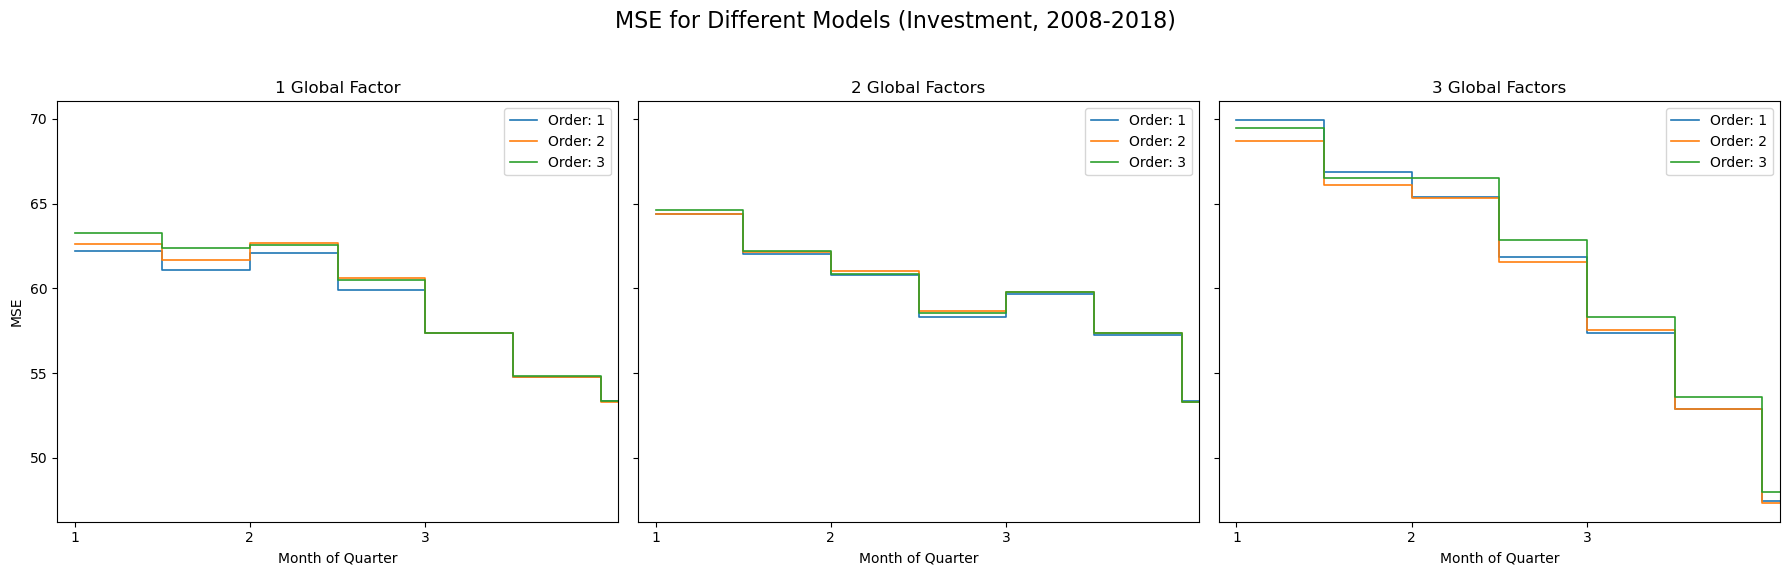

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


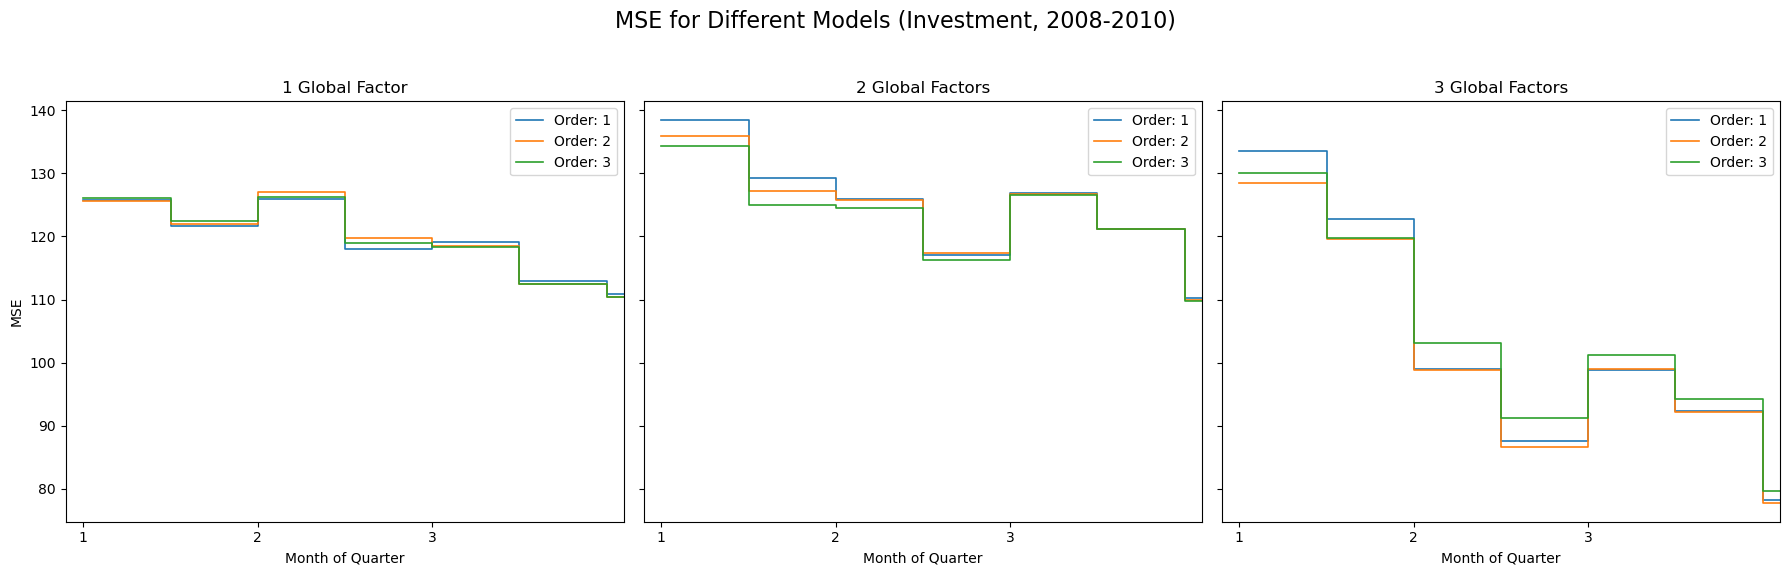

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


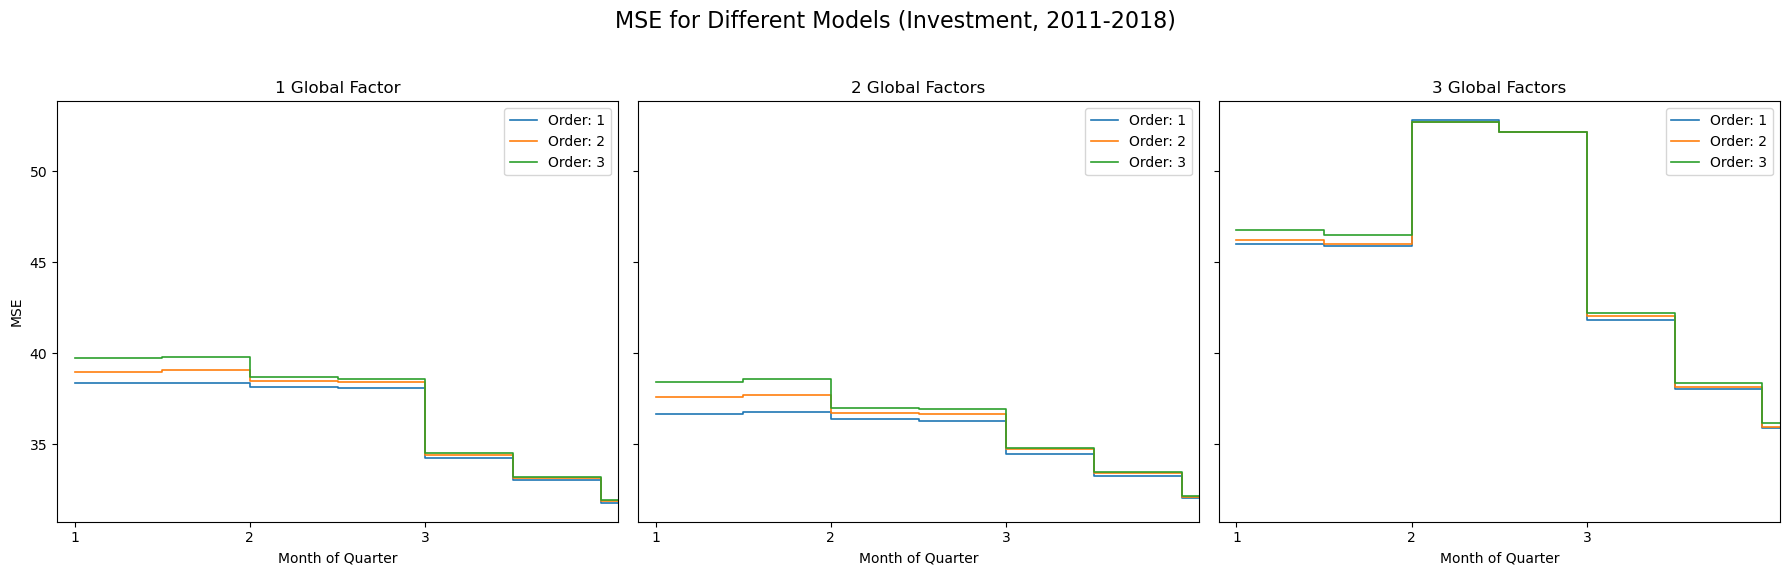

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


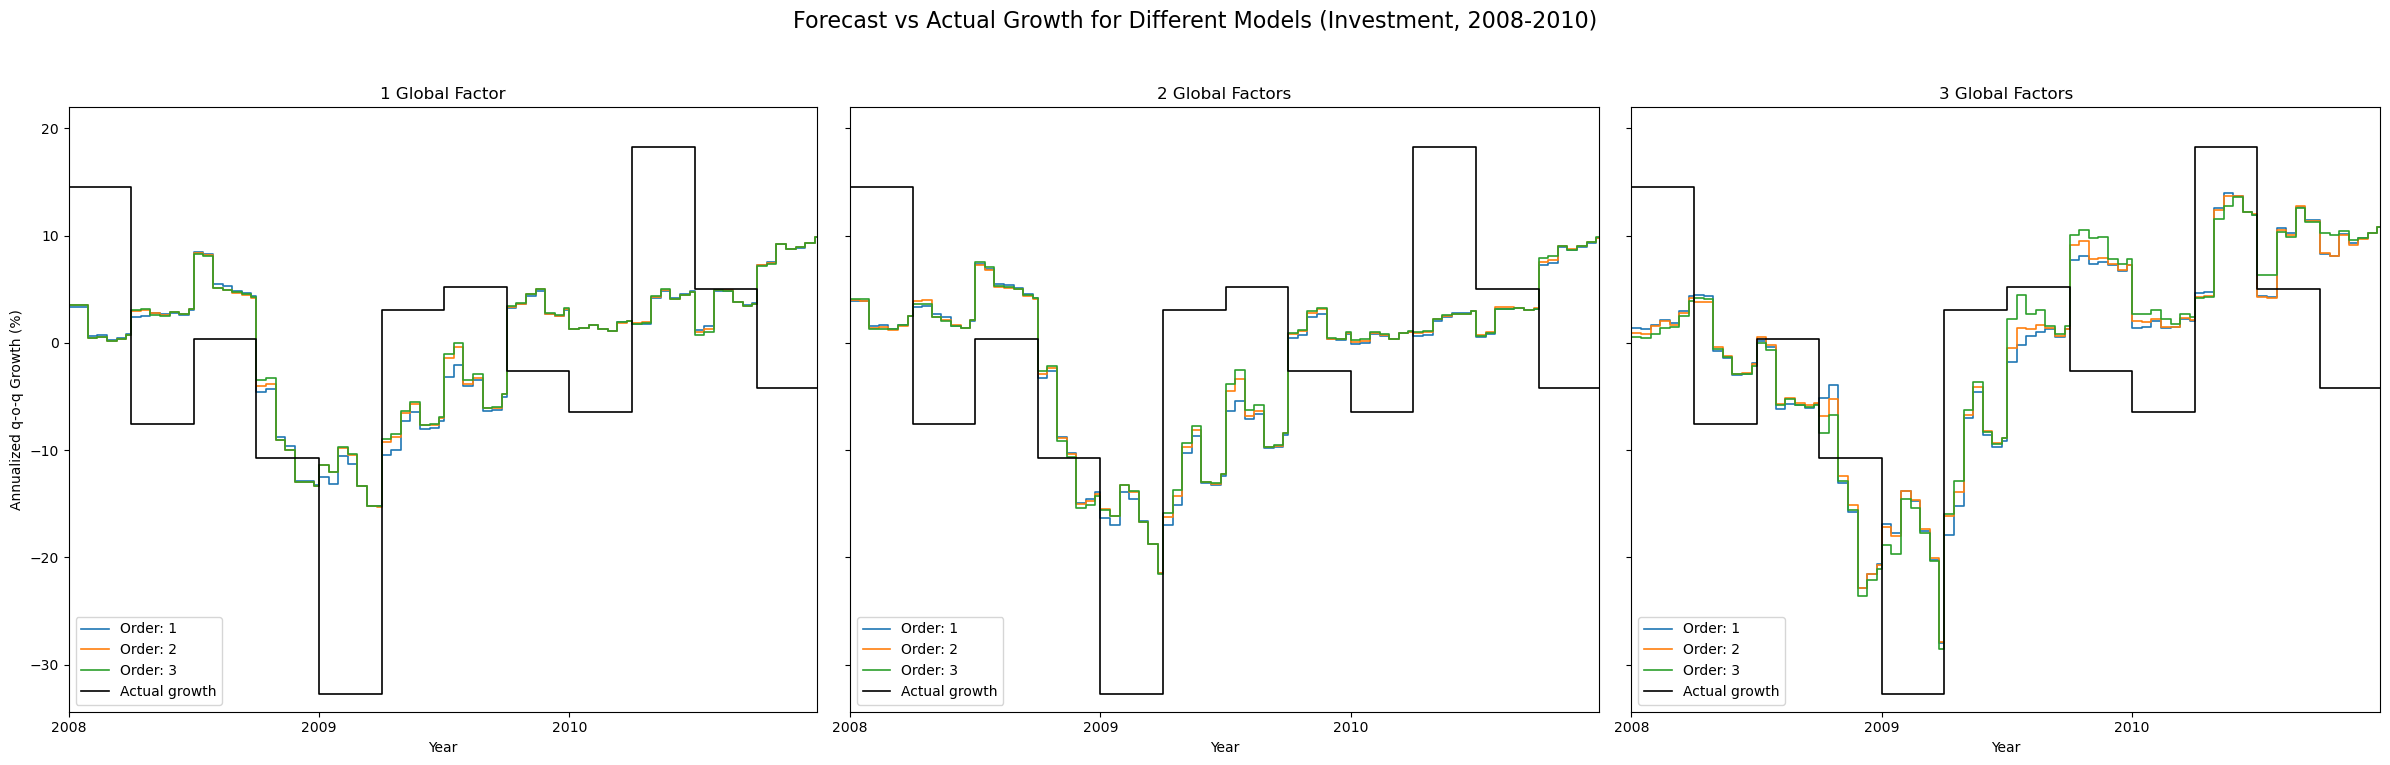

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


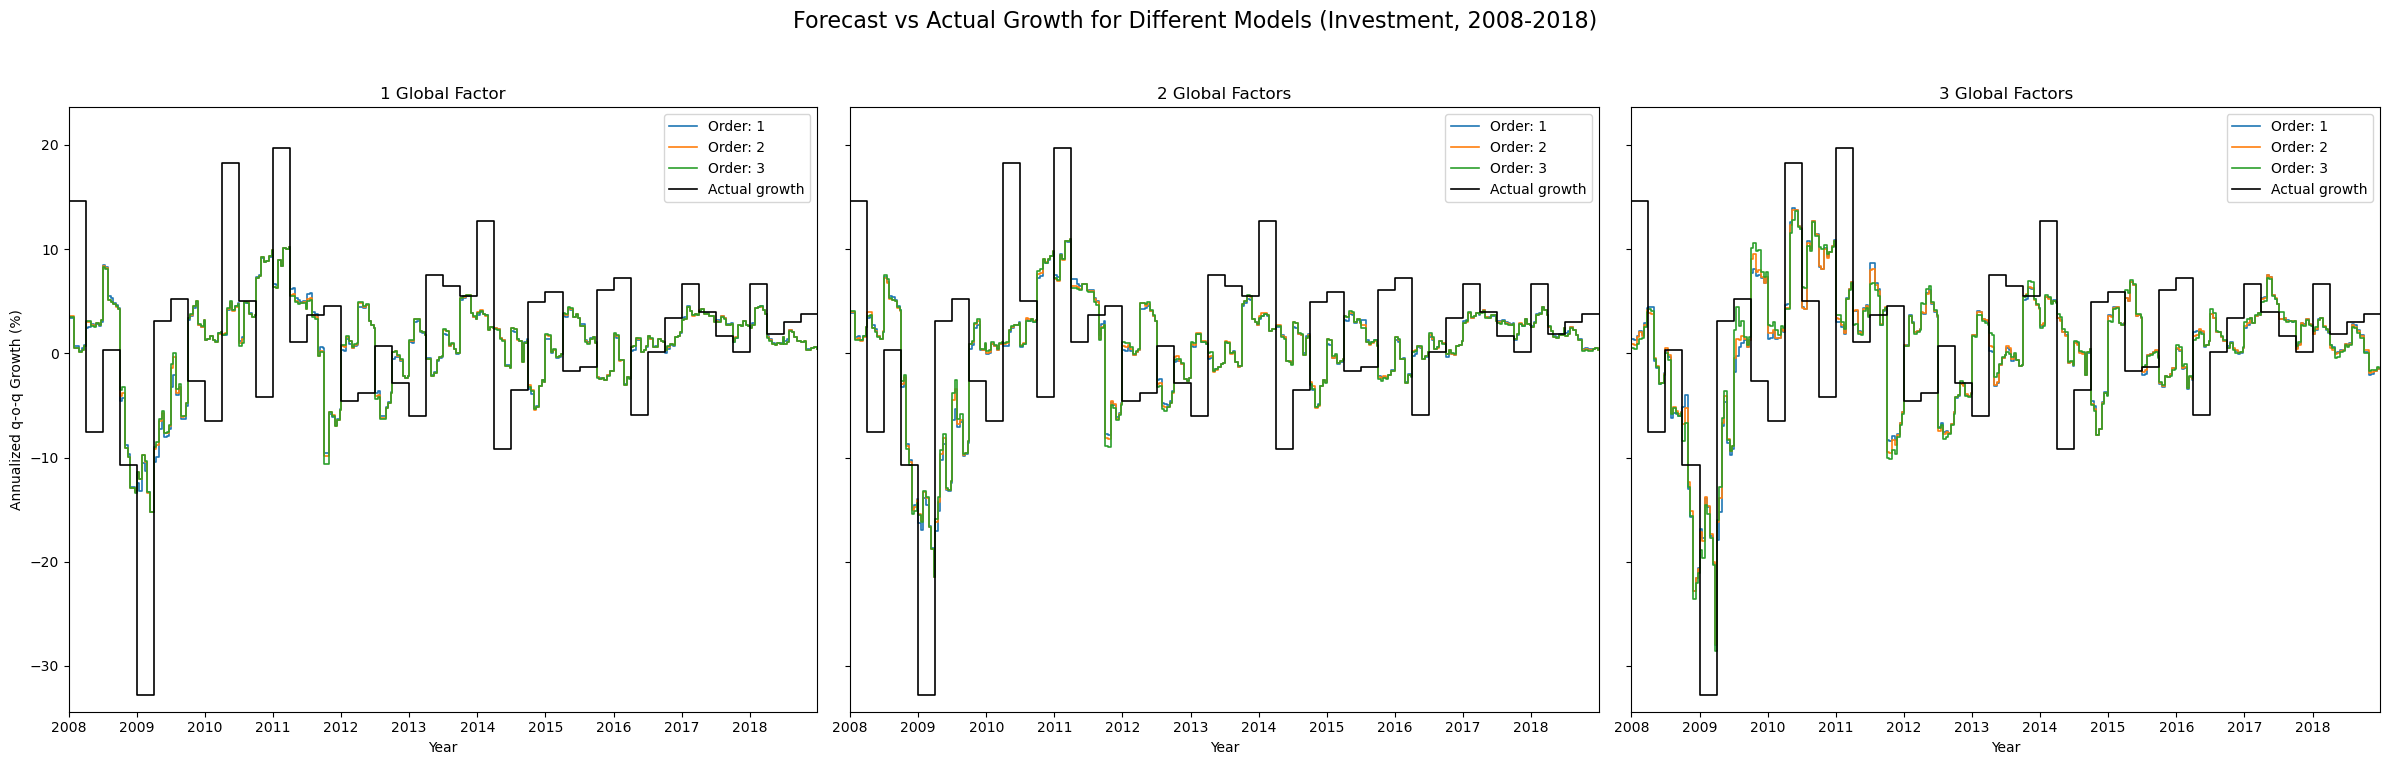

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


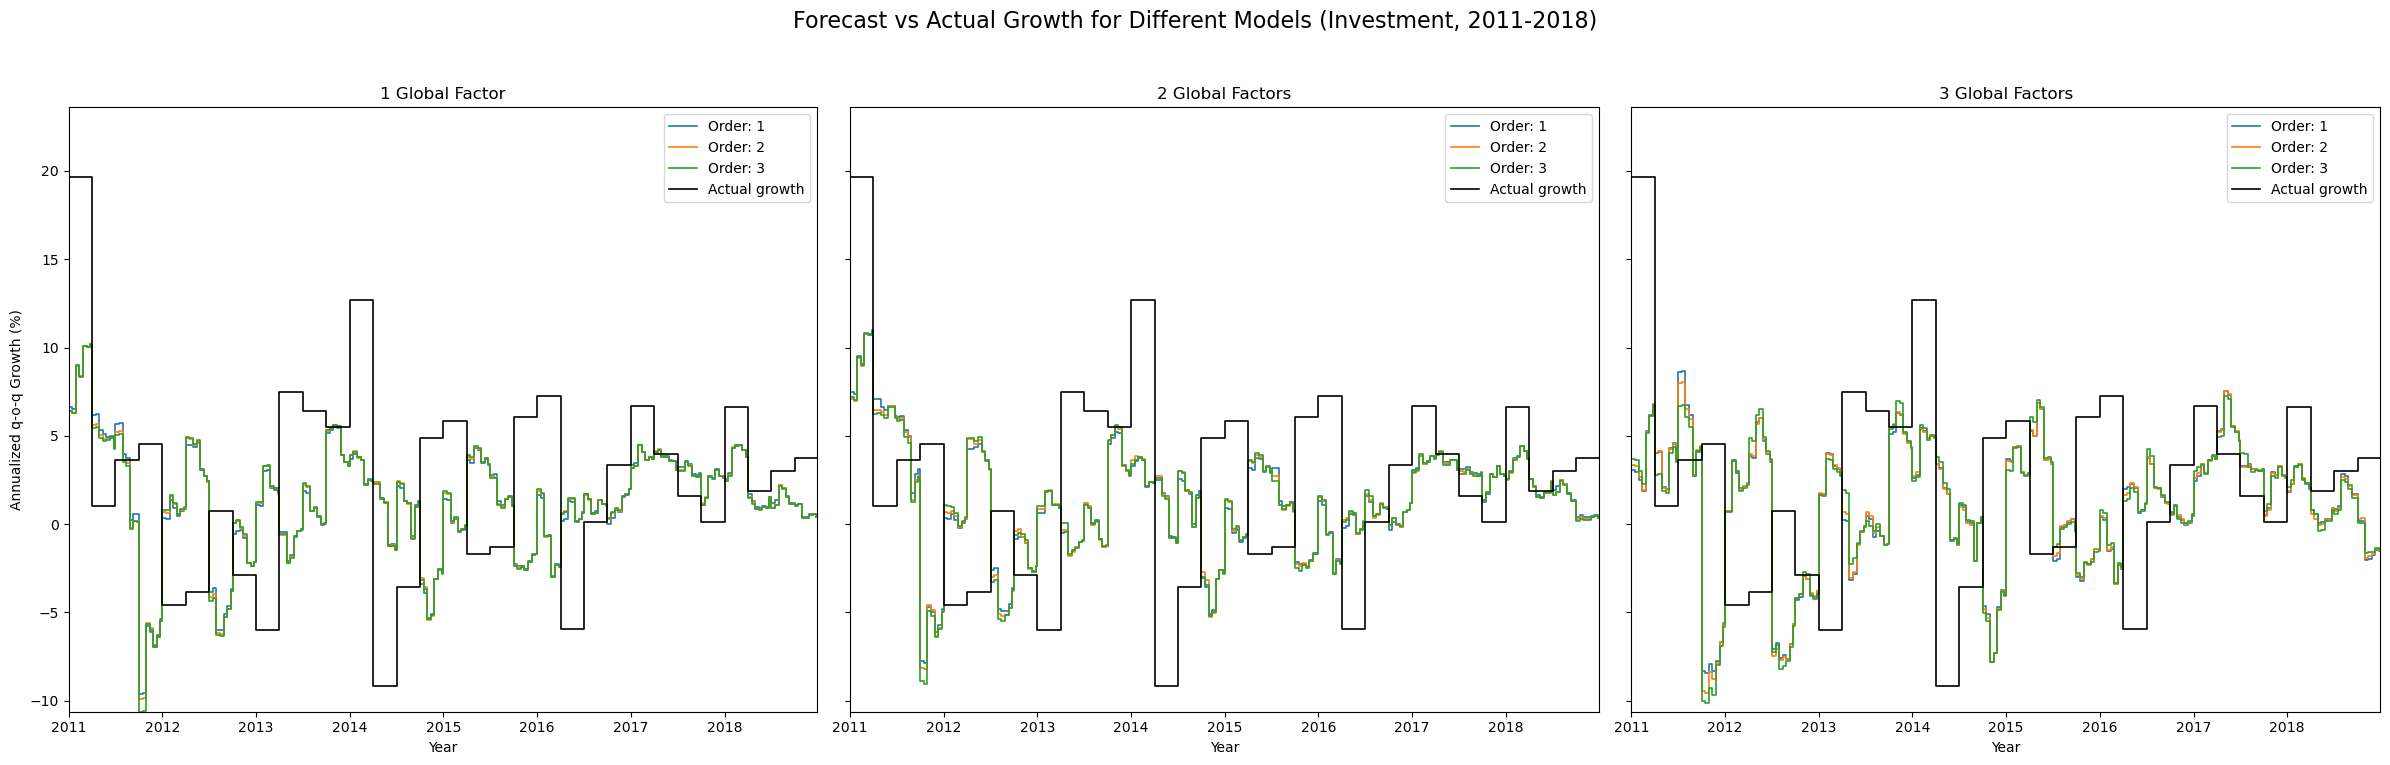

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()